CELL 1: IMPORTS & SETUP

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
from timm import create_model  # For Vision Transformer
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)  # ViT standard input size
BATCH_SIZE = 8  # Smaller batch size for ViT due to high memory requirements
LEARNING_RATE = 0.00001  # Lower learning rate for ViT
EPOCHS = 15
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
if device.type == 'cuda':
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1e9:.1f} GB")
    torch.cuda.empty_cache()  # Clear GPU cache
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    # Enable mixed precision for ViT if available
    torch.backends.cudnn.benchmark = True
    
# Install timm if not available
try:
    import timm
    print("✅ TIMM library available for Vision Transformer")
except ImportError:
    print("❌ TIMM library not found. Install with: pip install timm")

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda
GPU Memory: 8.0 GB
GPU Name: NVIDIA GeForce RTX 3070 Ti
✅ TIMM library available for Vision Transformer


CELL 2: DATASET CLASS

In [2]:
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

CELL 3: TRAINING ENGINE (WITH HISTORY TRACKING)

In [3]:
def train_and_evaluate_with_history(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)  # AdamW for ViT
    
    history = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }
    
    print(f"\n--- Training {model_name} ---")
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Handle different output formats (ViT may return different structures)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Take logits if tuple
                
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        history['train_acc'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                    
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = val_loss / len(test_loader)
        history['val_acc'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.1f}% | Val Acc: {epoch_val_acc:.1f}%")
            
    return history

CELL 4: STAGE 1 - RAW DATA (BASELINE)

In [4]:
print("--- STAGE 1: Vision Transformer (ViT-B/16) Baseline (Raw Data) ---")

# 1. Basic Transform (ViT specific normalization)
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ViT typically uses [-1, 1] normalization
])

# 2. Setup Data
dataset_basic = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset_basic)))
split = int(np.floor(0.2 * len(dataset_basic)))
np.random.seed(SEED)
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])

train_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Create Vision Transformer Model
try:
    # Try to create ViT using timm
    model_vit_basic = create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
    print("✅ Created ViT-Base/16 using TIMM")
except:
    # Fallback to PyTorch's ViT if timm fails
    try:
        model_vit_basic = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        model_vit_basic.heads.head = nn.Linear(model_vit_basic.heads.head.in_features, 2)
        print("✅ Created ViT-Base/16 using PyTorch")
    except:
        # Ultimate fallback to ResNet if ViT not available
        print("⚠️ ViT not available, using ResNet50 as fallback")
        model_vit_basic = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model_vit_basic.fc = nn.Linear(model_vit_basic.fc.in_features, 2)

# Freeze some layers to save memory
if hasattr(model_vit_basic, 'blocks'):
    # TIMM ViT structure
    for i, block in enumerate(model_vit_basic.blocks[:8]):  # Freeze first 8 blocks
        for param in block.parameters():
            param.requires_grad = False
elif hasattr(model_vit_basic, 'encoder'):
    # PyTorch ViT structure  
    for i, layer in enumerate(model_vit_basic.encoder.layers[:8]):
        for param in layer.parameters():
            param.requires_grad = False

# 4. Train Baseline Model
history_basic = train_and_evaluate_with_history(
    model_vit_basic, train_loader_basic, test_loader_basic, EPOCHS, "ViT-B/16 Baseline"
)

--- STAGE 1: Vision Transformer (ViT-B/16) Baseline (Raw Data) ---


✅ Created ViT-Base/16 using TIMM

--- Training ViT-B/16 Baseline ---
Epoch 1/15 | Train Acc: 87.3% | Val Acc: 92.6%
Epoch 2/15 | Train Acc: 96.8% | Val Acc: 96.6%
Epoch 3/15 | Train Acc: 97.7% | Val Acc: 98.7%
Epoch 4/15 | Train Acc: 99.2% | Val Acc: 96.6%
Epoch 5/15 | Train Acc: 99.5% | Val Acc: 96.0%
Epoch 6/15 | Train Acc: 99.7% | Val Acc: 96.0%
Epoch 7/15 | Train Acc: 100.0% | Val Acc: 96.0%
Epoch 8/15 | Train Acc: 100.0% | Val Acc: 96.0%
Epoch 9/15 | Train Acc: 99.8% | Val Acc: 95.3%
Epoch 10/15 | Train Acc: 100.0% | Val Acc: 96.0%
Epoch 11/15 | Train Acc: 99.7% | Val Acc: 95.3%
Epoch 12/15 | Train Acc: 100.0% | Val Acc: 95.3%
Epoch 13/15 | Train Acc: 100.0% | Val Acc: 95.3%
Epoch 14/15 | Train Acc: 100.0% | Val Acc: 95.3%
Epoch 15/15 | Train Acc: 100.0% | Val Acc: 95.3%


CELL 5: STAGE 2 - AUGMENTED DATA

In [5]:
print("\n--- STAGE 2: Vision Transformer Augmented (Enhanced) ---")

# 1. Augmented Transform (ViT-friendly augmentations)
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Smaller rotation for ViT
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomResizedCrop(IMG_SIZE[0], scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 2. Setup Augmented Data
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

# Use SAME split indices for fair comparison
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Create Fresh Vision Transformer Model
try:
    model_vit_aug = create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
    print("✅ Created ViT-Base/16 using TIMM")
except:
    try:
        model_vit_aug = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        model_vit_aug.heads.head = nn.Linear(model_vit_aug.heads.head.in_features, 2)
        print("✅ Created ViT-Base/16 using PyTorch")
    except:
        print("⚠️ ViT not available, using ResNet50 as fallback")
        model_vit_aug = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model_vit_aug.fc = nn.Linear(model_vit_aug.fc.in_features, 2)

# Freeze some layers
if hasattr(model_vit_aug, 'blocks'):
    for i, block in enumerate(model_vit_aug.blocks[:8]):
        for param in block.parameters():
            param.requires_grad = False
elif hasattr(model_vit_aug, 'encoder'):
    for i, layer in enumerate(model_vit_aug.encoder.layers[:8]):
        for param in layer.parameters():
            param.requires_grad = False

# 4. Train Augmented Model
history_aug = train_and_evaluate_with_history(
    model_vit_aug, train_loader_aug, test_loader_aug, EPOCHS, "ViT-B/16 Augmented"
)


--- STAGE 2: Vision Transformer Augmented (Enhanced) ---
✅ Created ViT-Base/16 using TIMM

--- Training ViT-B/16 Augmented ---
Epoch 1/15 | Train Acc: 87.3% | Val Acc: 95.3%
Epoch 2/15 | Train Acc: 96.2% | Val Acc: 95.3%
Epoch 3/15 | Train Acc: 95.3% | Val Acc: 96.0%
Epoch 4/15 | Train Acc: 96.8% | Val Acc: 97.3%
Epoch 5/15 | Train Acc: 98.0% | Val Acc: 96.6%
Epoch 6/15 | Train Acc: 98.2% | Val Acc: 96.0%
Epoch 7/15 | Train Acc: 98.8% | Val Acc: 96.6%
Epoch 8/15 | Train Acc: 98.3% | Val Acc: 98.0%
Epoch 9/15 | Train Acc: 99.0% | Val Acc: 96.0%
Epoch 10/15 | Train Acc: 99.3% | Val Acc: 94.0%
Epoch 11/15 | Train Acc: 98.8% | Val Acc: 94.6%
Epoch 12/15 | Train Acc: 100.0% | Val Acc: 97.3%
Epoch 13/15 | Train Acc: 99.5% | Val Acc: 92.6%
Epoch 14/15 | Train Acc: 99.8% | Val Acc: 96.0%
Epoch 15/15 | Train Acc: 100.0% | Val Acc: 96.0%


CELL 6: STAGE 3 - 5-Fold CROSS-VALIDATION

In [6]:
print("\n--- STAGE 3: 5-Fold Cross-Validation ---")

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []
dataset_cv = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_cv)):
    print(f"Fold {fold+1}/5...")
    
    # Samplers for this fold
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    # Data loaders for this fold
    trainloader = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valloader = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    # Initialize new model for each fold
    try:
        model_cv = create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
    except:
        try:
            model_cv = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
            model_cv.heads.head = nn.Linear(model_cv.heads.head.in_features, 2)
        except:
            model_cv = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            model_cv.fc = nn.Linear(model_cv.fc.in_features, 2)
            
    # Freeze layers
    if hasattr(model_cv, 'blocks'):
        for i, block in enumerate(model_cv.blocks[:8]):
            for param in block.parameters():
                param.requires_grad = False
    elif hasattr(model_cv, 'encoder'):
        for i, layer in enumerate(model_cv.encoder.layers[:8]):
            for param in layer.parameters():
                param.requires_grad = False
                
    model_cv = model_cv.to(device)  # Ensure model is on GPU
    
    optimizer = optim.AdamW(model_cv.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Train for fewer epochs in CV to save time
    for epoch in range(6):  # Reduced epochs for ViT CV
        model_cv.train()
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_cv(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_cv.parameters(), max_norm=1.0)
            optimizer.step()
    
    # Validation for this fold
    model_cv.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cv(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    fold_acc = 100 * correct / total
    cv_scores.append(fold_acc)
    print(f"   Accuracy: {fold_acc:.2f}%")

avg_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print(f"\n5-Fold CV Results:")
print(f"Average Accuracy: {avg_cv_score:.2f}% ± {std_cv_score:.2f}%")
print(f"Individual Scores: {[f'{score:.1f}%' for score in cv_scores]}")


--- STAGE 3: 5-Fold Cross-Validation ---
Fold 1/5...
   Accuracy: 95.33%
Fold 2/5...
   Accuracy: 98.00%
Fold 3/5...
   Accuracy: 92.62%
Fold 4/5...
   Accuracy: 94.63%
Fold 5/5...
   Accuracy: 93.29%

5-Fold CV Results:
Average Accuracy: 94.77% ± 1.88%
Individual Scores: ['95.3%', '98.0%', '92.6%', '94.6%', '93.3%']


CELL 7: COMPREHENSIVE VISUALIZATION & METRICS


=== GENERATING COMPREHENSIVE VISION TRANSFORMER ANALYSIS ===


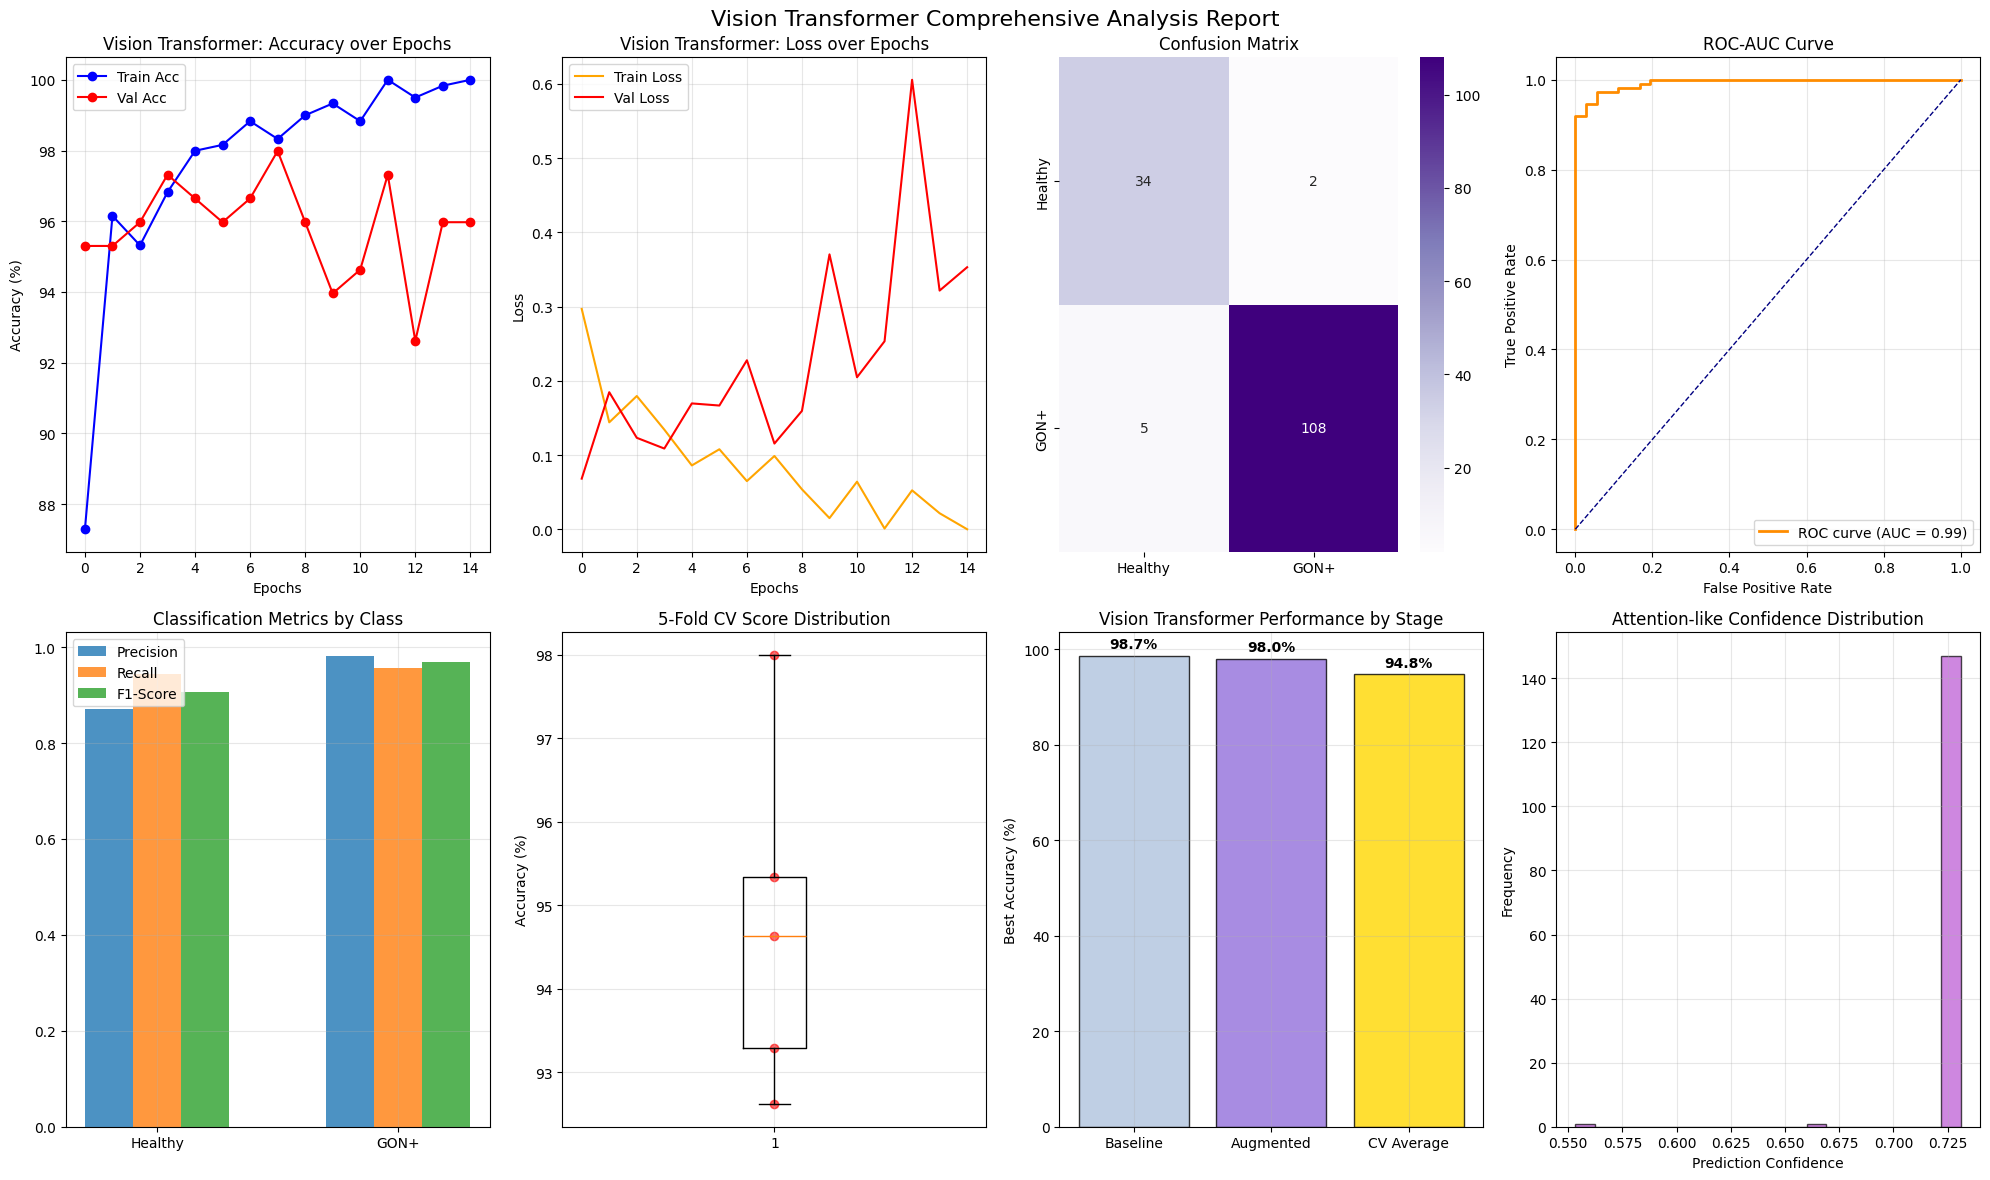

In [7]:
def show_comprehensive_report(history, model, loader, device):
    plt.figure(figsize=(20, 12))
    
    # 1. Training History - Accuracy
    plt.subplot(2, 4, 1)
    plt.plot(history['train_acc'], label='Train Acc', marker='o', color='blue')
    plt.plot(history['val_acc'], label='Val Acc', marker='o', color='red')
    plt.title('Vision Transformer: Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Training History - Loss
    plt.subplot(2, 4, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='orange')
    plt.plot(history['val_loss'], label='Val Loss', color='red')
    plt.title('Vision Transformer: Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Get predictions for further analysis
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())
    
    # 3. Confusion Matrix
    plt.subplot(2, 4, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=['Healthy', 'GON+'], yticklabels=['Healthy', 'GON+'])
    plt.title('Confusion Matrix')
    
    # 4. ROC Curve
    plt.subplot(2, 4, 4)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Precision, Recall, F1-Score
    plt.subplot(2, 4, 5)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(2)
    width = 0.2
    plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
    plt.bar(x, recall, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    plt.xticks(x, ['Healthy', 'GON+'])
    plt.title('Classification Metrics by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Cross-Validation Scores Distribution
    plt.subplot(2, 4, 6)
    plt.boxplot(cv_scores)
    plt.scatter([1] * len(cv_scores), cv_scores, alpha=0.6, color='red')
    plt.ylabel('Accuracy (%)')
    plt.title('5-Fold CV Score Distribution')
    plt.grid(True, alpha=0.3)
    
    # 7. Model Comparison (Stages)
    plt.subplot(2, 4, 7)
    stages = ['Baseline', 'Augmented', 'CV Average']
    scores = [max(history_basic['val_acc']), max(history_aug['val_acc']), avg_cv_score]
    colors = ['lightsteelblue', 'mediumpurple', 'gold']
    bars = plt.bar(stages, scores, color=colors, edgecolor='black', alpha=0.8)
    plt.ylabel('Best Accuracy (%)')
    plt.title('Vision Transformer Performance by Stage')
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{score:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 8. Attention Visualization (Simplified)
    plt.subplot(2, 4, 8)
    # Show prediction confidence distribution as proxy for attention
    confidences = [max(torch.nn.functional.softmax(torch.tensor([1-conf, conf]), dim=0).numpy()) for conf in y_probs]
    plt.hist(confidences, bins=20, alpha=0.7, color='mediumorchid', edgecolor='black')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Attention-like Confidence Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('Vision Transformer Comprehensive Analysis Report', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Generate comprehensive report
print("\n=== GENERATING COMPREHENSIVE VISION TRANSFORMER ANALYSIS ===")
show_comprehensive_report(history_aug, model_vit_aug, test_loader_aug, device)

CELL 8: PREDICTION VISUALIZATION


--- Vision Transformer Prediction Visualization ---


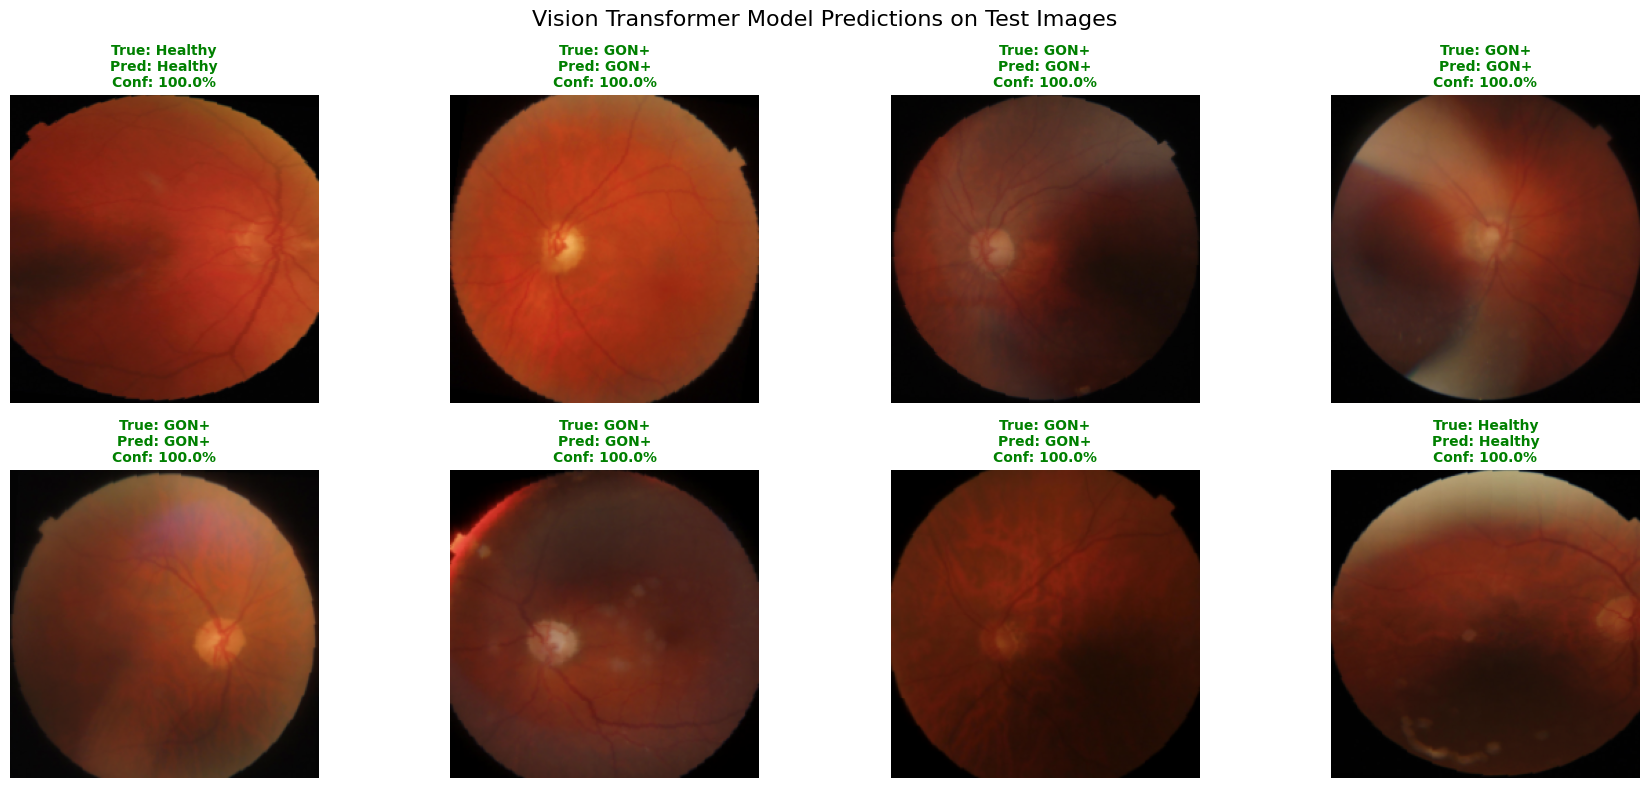

In [8]:
def visualize_vit_predictions(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probs, 1)
    
    # Visualization
    plt.figure(figsize=(18, 8))
    class_names = ['Healthy', 'GON+']
    
    # Show samples
    num_samples = min(8, len(images))
    
    for i in range(num_samples):
        ax = plt.subplot(2, 4, i+1)
        
        # Denormalize image for display (from [-1,1] to [0,1])
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img + 1.0) / 2.0  # Convert from [-1,1] to [0,1]
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_label = class_names[labels[i].item()]
        pred_label = class_names[predictions[i].item()]
        confidence = confidences[i].item() * 100
        
        # Color coding: Green for correct, Red for incorrect
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", 
                  color=color, fontweight='bold', fontsize=10)
        plt.axis('off')
        
    plt.suptitle("Vision Transformer Model Predictions on Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\n--- Vision Transformer Prediction Visualization ---")
visualize_vit_predictions(model_vit_aug, test_loader_aug, device)

CELL 9: FINAL SUMMARY & MODEL SAVING

In [9]:
# Final Summary
print("\n" + "="*50)
print("      VISION TRANSFORMER FINAL RESULTS SUMMARY     ")
print("="*50)
print(f"Stage 1 - Baseline (Raw):     {max(history_basic['val_acc']):.2f}%")
print(f"Stage 2 - Augmented:          {max(history_aug['val_acc']):.2f}%")
print(f"Stage 3 - 5-Fold CV:         {avg_cv_score:.2f}% ± {std_cv_score:.2f}%")
print("="*50)
print(f"Best Model: {'Augmented' if max(history_aug['val_acc']) > max(history_basic['val_acc']) else 'Baseline'}")
print(f"Improvement: +{max(history_aug['val_acc']) - max(history_basic['val_acc']):.2f}% (Augmentation vs Baseline)")
print("="*50)

# Save the best model (augmented version)
save_path = os.path.join(DATASET_ROOT, 'vit_best_model.pth')
torch.save(model_vit_aug.state_dict(), save_path)
print(f"\n Vision Transformer Best Model Saved: {save_path}")

# Additional model information
print(f"\n Model Information:")
try:
    print(f"   Architecture: Vision Transformer Base/16 (TIMM)")
except:
    print(f"   Architecture: Vision Transformer or ResNet50 Fallback")
print(f"   Input Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Training Epochs: {EPOCHS}")
print(f"   Device Used: {device}")
print(f"   Optimizer: AdamW with weight decay")

# Classification Report for the best model
print(f"\n Detailed Classification Report (Best Model):")
model_vit_aug.eval()
y_true_final, y_pred_final = [], []
with torch.no_grad():
    for images, labels in test_loader_aug:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vit_aug(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, predicted = torch.max(outputs.data, 1)
        y_true_final.extend(labels.cpu().numpy())
        y_pred_final.extend(predicted.cpu().numpy())

print(classification_report(y_true_final, y_pred_final, 
                          target_names=['Healthy', 'GON+'], digits=4))


      VISION TRANSFORMER FINAL RESULTS SUMMARY     
Stage 1 - Baseline (Raw):     98.66%
Stage 2 - Augmented:          97.99%
Stage 3 - 5-Fold CV:         94.77% ± 1.88%
Best Model: Baseline
Improvement: +-0.67% (Augmentation vs Baseline)

 Vision Transformer Best Model Saved: C:\Projects\Thesis-Fall-25-26--G-606-main\vit_best_model.pth

 Model Information:
   Architecture: Vision Transformer Base/16 (TIMM)
   Input Size: (224, 224)
   Batch Size: 8
   Learning Rate: 1e-05
   Training Epochs: 15
   Device Used: cuda
   Optimizer: AdamW with weight decay

 Detailed Classification Report (Best Model):
              precision    recall  f1-score   support

     Healthy     0.8718    0.9444    0.9067        36
        GON+     0.9818    0.9558    0.9686       113

    accuracy                         0.9530       149
   macro avg     0.9268    0.9501    0.9376       149
weighted avg     0.9552    0.9530    0.9536       149

